In [6]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,matthews_corrcoef as mat,confusion_matrix,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

In [9]:
df=pd.read_csv("parkinsons.csv")

In [10]:
x=df.drop(['status','name'],axis=1)
norm = MinMaxScaler().fit(x)
X= norm.transform(x)

y=df['status']
x_train,x_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=10)

In [11]:
bestfeatures = SelectKBest(score_func=chi2, k=12)
fit = bestfeatures.fit(x_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
featureScores['Specs'].values
print(featureScores.nlargest(12,'Score')) 

               Specs     Score
2       MDVP:Flo(Hz)  3.355342
18           spread1  3.308019
21               PPE  3.150308
10      Shimmer:APQ3  2.656304
13       Shimmer:DDA  2.655040
8       MDVP:Shimmer  2.622205
11      Shimmer:APQ5  2.417668
9   MDVP:Shimmer(dB)  2.339823
12          MDVP:APQ  1.996787
19           spread2  1.455480
16              RPDE  1.425923
6           MDVP:PPQ  1.389665


<AxesSubplot:xlabel='status', ylabel='count'>

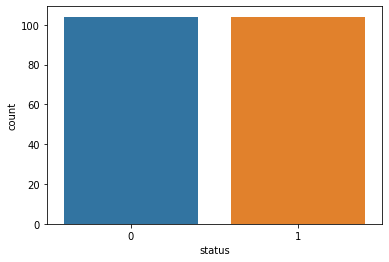

In [12]:
from imblearn.combine import SMOTETomek
smk = SMOTE(random_state=5)

## fit_resample() <- fit_sample
X_res,y_res=smk.fit_resample(x_train,y_train)
sns.countplot(x=y_res)

In [13]:
new_model=CatBoostClassifier(depth=10, iterations=70, learning_rate= 0.04)
new_model.fit(X_res, y_res)

0:	learn: 0.6504013	total: 217ms	remaining: 15s
1:	learn: 0.6111297	total: 271ms	remaining: 9.22s
2:	learn: 0.5723925	total: 322ms	remaining: 7.18s
3:	learn: 0.5397645	total: 370ms	remaining: 6.1s
4:	learn: 0.5035074	total: 417ms	remaining: 5.42s
5:	learn: 0.4711968	total: 466ms	remaining: 4.97s
6:	learn: 0.4415536	total: 555ms	remaining: 5s
7:	learn: 0.4145680	total: 598ms	remaining: 4.63s
8:	learn: 0.3908207	total: 645ms	remaining: 4.37s
9:	learn: 0.3653855	total: 692ms	remaining: 4.15s
10:	learn: 0.3463943	total: 739ms	remaining: 3.96s
11:	learn: 0.3264368	total: 784ms	remaining: 3.79s
12:	learn: 0.3098170	total: 794ms	remaining: 3.48s
13:	learn: 0.2955904	total: 841ms	remaining: 3.36s
14:	learn: 0.2827370	total: 892ms	remaining: 3.27s
15:	learn: 0.2708464	total: 937ms	remaining: 3.16s
16:	learn: 0.2616855	total: 988ms	remaining: 3.08s
17:	learn: 0.2471271	total: 1.03s	remaining: 2.98s
18:	learn: 0.2368538	total: 1.09s	remaining: 2.92s
19:	learn: 0.2242304	total: 1.14s	remaining: 2.

In [14]:
y_pred=new_model.predict(x_test)
acc2=accuracy_score(y_test,y_pred)
acc2

0.9661016949152542

In [15]:
print(classification_report(y_test,y_pred))
math2=mat(y_test,y_pred)
math2

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.98      0.98      0.98        43

    accuracy                           0.97        59
   macro avg       0.96      0.96      0.96        59
weighted avg       0.97      0.97      0.97        59



0.9142441860465116

In [16]:
### eval_metric='error' - te remove deprecation warning
### missing = 1 instead of 'None'
### use_label_encoder=False

xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.0,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=1, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1, eval_metric='error',
              use_label_encoder=False)
xgb.fit(X_res,y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='error',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, silent=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [17]:
predict_xgb=xgb.predict(x_test)
accu_xgb=accuracy_score(y_test,predict_xgb)

In [18]:
accu_xgb

0.9491525423728814

In [19]:
print(classification_report(y_test,predict_xgb))
math2=mat(y_test,predict_xgb)
math2

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.98      0.95      0.96        43

    accuracy                           0.95        59
   macro avg       0.93      0.95      0.94        59
weighted avg       0.95      0.95      0.95        59



0.8746154593939881

In [20]:
model=RandomForestClassifier(criterion='gini',max_depth= 9, n_estimators= 200)
model.fit(X_res,y_res)

RandomForestClassifier(max_depth=9, n_estimators=200)

In [21]:

modelExtra=ExtraTreesClassifier()
modelExtra.fit(x_train,y_train)

ExtraTreesClassifier()

In [22]:

y_predExtra=modelExtra.predict(x_test)
print(accuracy_score(y_test, y_predExtra)*100)

89.83050847457628
